## import

In [1]:
## on hubel, set python interpreter path: C:\Users\ll357\AppData\Local\anaconda3\python.exe

import os
import warnings
from tqdm import tqdm
import pickle
from IPython.display import clear_output

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from statsmodels.stats.proportion import proportion_confint
from sklearn.svm import LinearSVC # NOTE: current scikit-learn ver: 1.2.2, not newest, beware with doc
    # Similar to SVC with parameter kernel=’linear’, but implemented in terms of liblinear rather than libsvm, 
    # so it has more flexibility in the choice of penalties and loss functions and 
    # should scale better to large numbers of samples.
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.model_selection import LeaveOneOut

%load_ext autoreload
%autoreload 2

## func

In [13]:
pd.options.mode.chained_assignment = None  # default='warn'

dir_data = r'\\duhs-user-nc1.dhe.duke.edu\dusom_glickfeldlab\All_Staff\home\lan\Data\2P_images\mat_inter/'.replace('\\', '/')
dir_repo = r'C:\Users\ll357\Documents\inter/'.replace('\\', '/')


def calc_SNR(df_tidy):
    ## SNR of R1, aka (R2 without adapter, isi=6k)
    tmp = df_tidy[(df_tidy.resp_id == 'R2') & (df_tidy.isi == 6000)].groupby(['cell_id', 'stim2_id']).dfof
    SNR_R1 = (tmp.mean() / tmp.std()).reset_index()
    
    ## modified SNR of R1: for cell, (max-min resp) / (median std over ori)
    dfof_range_ori = (df_tidy[(df_tidy.resp_id == 'R2') & (df_tidy.isi == 6000)]
                    .groupby(['cell_id', 'stim2_id'])
                    .dfof.mean().reset_index() # mean dfof for each cell and each stim2_id
                    .groupby('cell_id').dfof.apply(lambda x: x.max() - x.min()) # max - min resp for each cell over all stim2_id
                    .reset_index()
                    .rename(columns={'dfof': 'dfof_range'})
                    )
    dfof_std_ori  = (df_tidy[(df_tidy.resp_id == 'R2') & (df_tidy.isi == 6000)]
                    .groupby(['cell_id', 'stim2_id'])
                    .dfof.std().reset_index()
                    .groupby('cell_id').dfof.median() # median std over stim2_id
                    .reset_index()
                    .rename(columns={'dfof': 'dfof_std_med'})
                    )
    SNR_R1_mod = dfof_range_ori.dfof_range / dfof_std_ori.dfof_std_med
    dfof_SNR_R1_mod = dfof_range_ori.copy()
    dfof_SNR_R1_mod['SNR_R1_mod'] = SNR_R1_mod

    ## SNR of R2, aka (R2 with adapter, isi=250)
    tmp = df_tidy[(df_tidy.resp_id == 'R2') & (df_tidy.isi == 250)].groupby(['cell_id', 'stim2_id']).dfof
    SNR_R2 = (tmp.mean() / tmp.std()).reset_index()

    ## merge to df
    df_SNR = SNR_R1.merge(SNR_R2, on=['cell_id', 'stim2_id'], suffixes=('_R1', '_R2'))
    df_SNR.columns = ['cell_id', 'stim2_id', 'SNR_R1', 'SNR_R2'] # rename columns
    df_SNR = df_SNR.merge(dfof_SNR_R1_mod, on=['cell_id'])
    df_SNR = df_SNR.sort_values(by='SNR_R1_mod', ascending=False)
    return df_SNR


def get_df_svc(df_tidy, iarea='V1', idatesess=0, ncell_keep=15, filter_cell='vis_pval'):
    df_svc = df_tidy[['dfof', 
                    'cell_id', 'resp_id', 'isi', 'stim2_id', 'trial_id',
                    'filter_cell_vis', 'filter_cell_stim', 'filter_cell_vis_pval',
                    'area', 'mouse', 'date', 'sess'
                    ]]

    df_svc['stim2_dist'] = df_svc.stim2_id.apply(lambda x: 22.5*(8-x) if x > 4 else 22.5*x) 
                            # stim2 distance from 0 deg, hard coded for 8 ori. TODO: modify if needed
    df_svc['date_sess'] = df_svc.date + '_' + df_svc.sess
    
    df_svc = df_svc[(df_svc.isi != 750)
                    & (df_svc.filter_cell_vis == True)
                    & (df_svc.resp_id == 'R2') # only decode R2, with or without adapter (differentiate by isi)
                    & (df_svc.area == iarea)
                    ]
    date_sess_now = df_svc.date_sess.unique()[idatesess] # sess id in a specific area, with filter_cell_vis=True
    df_svc = df_svc[df_svc.date_sess == date_sess_now]

    if df_svc.cell_id.nunique() > ncell_keep:
        
        if filter_cell == 'vis_pval':
            vis_pval_thresh = (df_svc.groupby('cell_id').first()
                            .filter_cell_vis_pval.sort_values() # ascending, smaller pval better
                            [ncell_keep]) # nsample (nrep trial) too small, need to reduce nfeature (ncell)
            df_svc = df_svc[df_svc.filter_cell_vis_pval < vis_pval_thresh]
        
        if filter_cell == 'SNR':
            df_SNR = calc_SNR(df_svc)
            model_cell_id = (df_SNR.groupby('cell_id')
                            .SNR_R1.max().reset_index()
                            .sort_values('SNR_R1', ascending=False)
                            .head(ncell_keep).cell_id.values
                            )
            df_svc = df_svc[df_svc.cell_id.isin(model_cell_id)]
            assert set(df_svc.cell_id.unique()) == set(sorted(model_cell_id))
            
        if filter_cell == 'SNR_R1_mod':
            df_SNR = calc_SNR(df_svc)
            model_cell_id = (df_SNR.groupby('cell_id')
                            .SNR_R1_mod.first().reset_index()
                            .sort_values('SNR_R1_mod', ascending=False)
                            .head(ncell_keep).cell_id.values
                            )
            df_svc = df_svc[df_svc.cell_id.isin(model_cell_id)]
            assert set(df_svc.cell_id.unique()) == set(sorted(model_cell_id))
            
        if filter_cell == 'gOSI':
            df_gOSI_sess = df_gOSI[df_gOSI.date_sess == date_sess_now]
            model_cell_id = (df_gOSI_sess.sort_values('gOSI_noad', ascending=False)
                             .head(ncell_keep).cell_id.values
                             )
            df_svc = df_svc[df_svc.cell_id.isin(model_cell_id)]
        
    return df_svc


def df_to_train_test(df, train_only=True):
    # input: filtered df_svc
    # output: X_train, X_test, y_train, y_test (of the filter condition)
    # train_only: only get train data from df, no test. 
        # use only train-val split in cross val, not train-val-test split
    
    label_arr = df.groupby('trial_id').stim2_dist.first().values
    label_arr = (label_arr == 90) # 1 = 90 deg, 0 = other ori
    
    feature_mat = (df
                   .pivot_table(index=['trial_id'], columns='cell_id', values='dfof')
                   .fillna(0).to_numpy())
    
    assert feature_mat.shape[0] == label_arr.shape[0]
    # print(label_arr.shape) # ntrial
    # print(feature_mat.shape) # ntrial x ncell
    
    if train_only == False:
        X_train, X_test, y_train, y_test = train_test_split(
            feature_mat, label_arr, test_size=int(1), # 1 trial for test. do not differentiate val/test now
            random_state=0, shuffle=True) 
        # print(X_train.shape, y_train.shape, X_test.shape, y_test.shape) # ntrial x ncell
        return X_train, y_train, X_test, y_test
    
    if train_only == True:
        X_train, y_train = feature_mat, label_arr
        return X_train, y_train, None, None

## df_tidy load

In [7]:
data_info = pd.read_excel(os.path.join(dir_data, 'adp_dataset_master.xlsx'))
meta = data_info[(data_info.paradigm == 'grating') 
                 & (data_info.area == 'LM')
                 & ((data_info.cellpose_seg == True) | (data_info.manual_seg == True))] # ensure segmentation
meta = meta.reset_index(drop=True)
nset = meta.shape[0]
print(meta.area.value_counts(), nset)
meta_LM = meta.copy()

meta = data_info[(data_info.paradigm == 'grating') 
                 & (data_info.area == 'V1') 
                 & (data_info.gcamp == '6s') # avoid mixing in gcamp8f
                 & ((data_info.cellpose_seg == True) | (data_info.manual_seg == True))] # there are 2 data in V1 that haven't been segmented due to cellpose failing with low quality tiff
meta = meta.reset_index(drop=True)
nset = meta.shape[0]
print(meta.area.value_counts(), nset)
meta_V1 = meta.copy()

meta = data_info[(data_info.paradigm == 'grating') 
                 & (data_info.area == 'LI') 
                 & (data_info.gcamp == '6s') # avoid mixing in gcamp8f
                 & (data_info.manual_seg != 'TODO') # 2 LI data still need manual segm
                 & (data_info.note.str.contains('bad') != True) # exclude bad data
                 ]
meta = meta.reset_index(drop=True)
nset = meta.shape[0]
print(meta.area.value_counts(), nset)
meta_LI = meta.copy()

meta = pd.concat([meta_V1, meta_LM, meta_LI], axis=0).reset_index(drop=True)

area
LM    22
Name: count, dtype: int64 22
area
V1    6
Name: count, dtype: int64 6
area
LI    18
Name: count, dtype: int64 18


In [4]:
nset = len(meta)
df_tidy = pd.DataFrame()

for iset in tqdm(range(nset)):
    # print(f'iset={iset}, nset={nset}')

    mouse = meta.loc[iset, 'mouse'].astype(str)
    imouse = 'i' + mouse
    date = meta.loc[iset, 'date'].astype(str)
    area = meta.loc[iset, 'area']
    # sess = '00' + meta.loc[iset, 'num'].astype(str)
    sess = meta.loc[iset, 'num']
    # print(imouse, date, area, sess)
    dir_identifier = f'{area}_{imouse}_{date}_{sess}'

    dir_data = r'\\duhs-user-nc1.dhe.duke.edu\dusom_glickfeldlab\All_Staff\home\lan\Data\2P_images\mat_inter/'.replace('\\', '/')
    csv_filename = 'df_tidy_continuous_vis_pval.csv'
    try:
        df_tidy_now = pd.read_csv(os.path.join(dir_data, dir_identifier, csv_filename))
    except:
        dir_identifier = dir_identifier + '_cellpose'
        df_tidy_now = pd.read_csv(os.path.join(dir_data, dir_identifier, csv_filename))

    df_tidy_now['mouse'] = mouse
    df_tidy_now['date'] = date
    df_tidy_now['sess'] = sess
    df_tidy_now['cell_id'] = (df_tidy_now.date.astype(str) + '_' 
                               + df_tidy_now.sess.astype(str) + '_' 
                               + df_tidy_now.cell_id.astype(str)) # cell_id adjusted to be unique across mice, dates, sessions
    df_tidy = pd.concat([df_tidy, df_tidy_now], axis=0).reset_index(drop=True)
    # break
    
clear_output()

# print(df_tidy.mouse.unique(), 
#       df_tidy.date.unique(), 
#       df_tidy.sess.unique(), 
#       df_tidy.area.unique(), 
#       df_tidy.isi.unique(), 
#       df_tidy.stim1_contrast.unique(), 
#       df_tidy.stim2_id.unique(), 
#       df_tidy.resp_id.unique())
# df_tidy.sample(5, random_state=0)

## goal: decode 90 vs another ori

## feature selection
reduce ncell in model to prevent overfit

### filter cell gOSI
calculate global orientation selectivity index (gOSI)  
formula taken from [Causal importance of orientation selectivity for generalization in image recognition](https://openreview.net/pdf?id=Bkx_Dj09tQ)

In [88]:
## df for tuning curve
df_tuning = df_tidy[['dfof', 'cell_id', 'resp_id', 'isi', 'stim2_id', 
                    'area', 'filter_cell_vis'
                    ]]
df_tuning = df_tuning[(df_tuning.isi > -1) # placeholder, always true
                    & (df_tuning.filter_cell_vis == True)
                    & ((df_tuning.isi == 250) | (df_tuning.isi == 6000))
                    ]
                    
df_tuning['tuning_noad'] = np.pi
df_tuning['tuning_250'] = np.pi

for icell in tqdm(df_tuning.cell_id.unique()):
    ## tuning curve when no adapter
    tuning_noad = (df_tuning.loc[(df_tuning.cell_id == icell) 
                                & (df_tuning.isi == 6000) # take R2 of no adapter trials
                                & (df_tuning.resp_id == 'R2'), :]
                   .groupby(['stim2_id'], sort=True) # sorted by key aka stim2_id
                   .dfof.agg(np.nanmean).values
                   )
    df_tuning.loc[(df_tuning.cell_id == icell), 'tuning_noad'] = (df_tuning
                                                                  .loc[(df_tuning.cell_id == icell), 'tuning_noad']
                                                                  .apply(lambda x: tuning_noad))
    
    ## tuning curve when there is adapter
    tuning_250 = (df_tuning.loc[(df_tuning.cell_id == icell) 
                                & (df_tuning.isi == 250) 
                                & (df_tuning.resp_id == 'R2'), :]
                  .groupby(['stim2_id'], sort=True)
                  .dfof.agg(np.nanmean).values
                  )
    df_tuning.loc[(df_tuning.cell_id == icell), 'tuning_250'] = (df_tuning
                                                                 .loc[(df_tuning.cell_id == icell), 'tuning_250']
                                                                 .apply(lambda x: tuning_250))
    # break

df_tuning.tail(5)

100%|██████████| 1654/1654 [17:19<00:00,  1.59it/s]


,dfof,cell_id,resp_id,isi,stim2_id,area,filter_cell_vis,tuning_noad,tuning_250
2379998,-0.025242,230309_002_79,R2,6000,3,LI,True,"[0.027171706755775783, 0.09794865820137698, 0....","[-0.008992726503453645, 0.003331566276028924, ..."
2379999,0.081034,230309_002_79,R2,6000,2,LI,True,"[0.027171706755775783, 0.09794865820137698, 0....","[-0.008992726503453645, 0.003331566276028924, ..."
2380001,0.108352,230309_002_79,R2,6000,0,LI,True,"[0.027171706755775783, 0.09794865820137698, 0....","[-0.008992726503453645, 0.003331566276028924, ..."
2380002,0.269638,230309_002_79,R2,250,4,LI,True,"[0.027171706755775783, 0.09794865820137698, 0....","[-0.008992726503453645, 0.003331566276028924, ..."
2380003,0.345687,230309_002_79,R2,6000,2,LI,True,"[0.027171706755775783, 0.09794865820137698, 0....","[-0.008992726503453645, 0.003331566276028924, ..."


In [89]:
for icell in tqdm(df_tuning.cell_id.unique()):
    df_cell = df_tuning[df_tuning.cell_id == icell]

    tuning_noad = df_cell.tuning_noad.values[0] - min(df_cell.tuning_noad.values[0]) # ensure all values are non negative
    tuning_250 = df_cell.tuning_250.values[0] - min(df_cell.tuning_250.values[0])

    theta_arr = np.linspace(0, 180-22.5, 8) # according to formula: unit deg, not rad
    sin_arr = np.sin(2 * theta_arr)
    cos_arr = np.cos(2 * theta_arr)

    gOSI_noad = np.sqrt((np.sum(tuning_noad * sin_arr))**2 + (np.sum(tuning_noad * cos_arr))**2) / np.sum(tuning_noad)
    gOSI_250 = np.sqrt((np.sum(tuning_250 * sin_arr))**2 + (np.sum(tuning_250 * cos_arr))**2) / np.sum(tuning_250)

    df_tuning.loc[df_tuning.cell_id == icell, 'gOSI_noad'] = gOSI_noad
    df_tuning.loc[df_tuning.cell_id == icell, 'gOSI_250'] = gOSI_250

df_tuning = df_tuning.sort_values(by=['gOSI_noad', 'gOSI_250'], ascending=False)
df_tuning.groupby('cell_id', sort=False)['area', 'gOSI_noad', 'gOSI_250'].first()
# df_tuning.to_csv('df_tuning_grat8ori.csv', index=False)

100%|██████████| 1654/1654 [06:46<00:00,  4.07it/s]
C:\Users\lan\AppData\Local\Temp\6\ipykernel_44780\3524770447.py:18: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_tuning.groupby('cell_id', sort=False)['area', 'gOSI_noad', 'gOSI_250'].first()


,area,gOSI_noad,gOSI_250
cell_id,,,
201209_002_88,V1,0.876308,0.682645
200728_003_33,V1,0.866154,0.729479
201015_004_15,V1,0.849340,0.496406
201015_004_12,V1,0.846736,0.789616
220228_002_16,LM,0.845744,0.809035
...,...,...,...
200728_003_72,V1,0.017878,0.317335
200804_003_68,LM,0.015051,0.136653
230302_003_136,LM,0.014923,0.443175


In [98]:
df_gOSI = df_tuning.groupby('cell_id', sort=False)[['gOSI_noad', 'gOSI_250']].first().reset_index()
df_gOSI['date_sess'] = df_gOSI['cell_id'].str.split('_').str[0] + '_' + df_gOSI['cell_id'].str.split('_').str[1]
df_gOSI

,cell_id,gOSI_noad,gOSI_250,date_sess
0,201209_002_88,0.876308,0.682645,201209_002
1,200728_003_33,0.866154,0.729479,200728_003
2,201015_004_15,0.849340,0.496406,201015_004
3,201015_004_12,0.846736,0.789616,201015_004
4,220228_002_16,0.845744,0.809035,220228_002
...,...,...,...,...
1649,200728_003_72,0.017878,0.317335,200728_003
1650,200804_003_68,0.015051,0.136653,200804_003
1651,230302_003_136,0.014923,0.443175,230302_003
1652,210120_003_34,0.011596,0.026943,210120_003


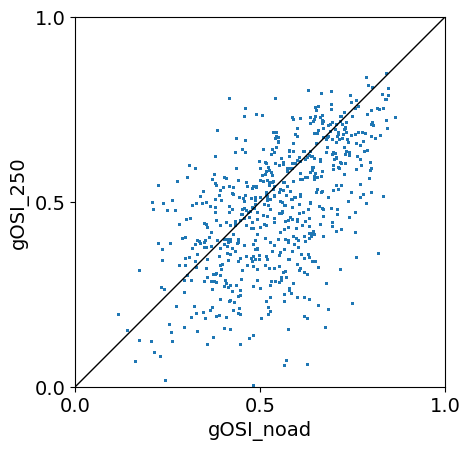

In [ ]:
tmp1 = df_tuning.sort_values(by=['gOSI_noad', 'gOSI_250'], ascending=False).gOSI_noad.values
tmp2 = df_tuning.sort_values(by=['gOSI_noad', 'gOSI_250'], ascending=False).gOSI_250.values

plt.scatter(tmp1, tmp2, alpha=.1, s=1);
plt.plot([0, 1], [0, 1], color='k', linestyle='-', linewidth=1); # draw diagonal line

plt.xlim([0, 1]);
plt.ylim([0, 1]);
plt.xticks([0, .5, 1]);
plt.yticks([0, .5, 1]);
plt.xlabel('gOSI_noad');
plt.ylabel('gOSI_250');
plt.gca().set_aspect('equal', adjustable='box'); # set axis square

## gOSI noad is usually higher. gOSI noad vs 250 is correlated

### validate tuning
neuron in model should have diff tuning curves

In [38]:
ncell_keep = 15
iarea = 'LI'
idatesess = 9
# filter_cell = 'vis_pval'
# filter_cell = 'SNR'
filter_cell = 'SNR_R1_mod'
# filter_cell = 'gOSI'

df_svc = get_df_svc(df_tidy, iarea=iarea, idatesess=idatesess, 
                    ncell_keep=ncell_keep, 
                    filter_cell=filter_cell)

# assert set(df_svc.cell_id.unique()) == set(calc_SNR(df_tidy[(df_tidy.date=='200720') 
#                     & (df_tidy.sess=='003')
#                     & (df_svc.filter_cell_vis == True)])
#     .groupby('cell_id')
#     .SNR_R1_mod.first().reset_index()
#     .sort_values('SNR_R1_mod', ascending=False).cell_id.values)

In [43]:
df_tidy[(df_tidy.date == '211028') & (df_tidy.sess == '003') & (df_tidy.filter_cell_vis == True)].cell_id.unique()

array(['211028_003_23'], dtype=object)

In [39]:
model_cell_resp = df_svc.groupby(['cell_id', 'stim2_id']).dfof.mean().reset_index()
model_cell_sem = df_svc.groupby(['cell_id', 'stim2_id']).dfof.sem().reset_index()

tuning_pop = []
tuning_pop_sem = []
for icell in sorted(df_svc.cell_id.unique()):
    tuning_cell = model_cell_resp[model_cell_resp.cell_id==icell].dfof.tolist()
    tuning_cell_sem = model_cell_sem[model_cell_sem.cell_id==icell].dfof.tolist()
    # tuning_cell = (tuning_cell - np.min(tuning_cell)) / (np.max(tuning_cell) - np.min(tuning_cell)) # min-max normalization
    tuning_pop.append(tuning_cell)
    tuning_pop_sem.append(tuning_cell_sem)

tuning_pop = np.array(tuning_pop) # ncell_keep x nori
tuning_pop_sem = np.array(tuning_pop_sem)
tuning_pop = tuning_pop[np.argsort(np.argmax(tuning_pop, axis=1)), :] # sort cells by tuning argmax
tuning_pop_sem = tuning_pop_sem[np.argsort(np.argmax(tuning_pop, axis=1)), :]

if ncell_keep > 15:
    nrow = 13
    ncol = df_svc.cell_id.nunique() // nrow
    fig, ax = plt.subplots(nrow, ncol, figsize=(10, 40), sharex=True, sharey=True)
else:
    nrow = 5
    ncol = df_svc.cell_id.nunique() // nrow
    fig, ax = plt.subplots(nrow, ncol, figsize=(10, 20), sharex=True, sharey=True)

for isubplot in np.arange(nrow*ncol): # plot each cell in a subplot
    ax[isubplot//ncol, isubplot%ncol].errorbar(x=np.arange(8), 
                                               y=tuning_pop[isubplot], 
                                               yerr=tuning_pop_sem[isubplot], 
                                               alpha=0.5)
    # ax[isubplot//ncol, isubplot%ncol].text(0.5, 0.9, 
    #             f'cell ' + sorted(df_svc.cell_id.unique())[isubplot].split('_')[2],
    #             horizontalalignment='center',
    #             transform=ax[isubplot//ncol, isubplot%ncol].transAxes,
    #             fontsize=14)
        
fig.text(0.5, -0.05, 'stim2 orientation', ha='center', fontsize=18)
fig.text(-0.02, 0.5, 'tuning', va='center', rotation='vertical', fontsize=18)
fig.tight_layout()

dir_fig = os.path.join(dir_repo, r'\results\decoder_grat8\filter cell selection/'.replace('\\', '/'))
# fig.savefig(dir_fig + 'tuning_of_model_cells_SNR_R1_mod.pdf', bbox_inches='tight')

ValueError: Number of columns must be a positive integer, not 0

<Figure size 1000x2000 with 0 Axes>

## cross val search reg
find optimal reg param C

### aware decoder

two separate models for two isi.  
one model: train and test with isi=6k  
another model: train and test with isi=250  

In [14]:
for iarea in ['V1', 'LM', 'LI']:
    nsess = df_tidy[df_tidy.area == iarea].groupby(['date', 'sess']).__len__()
    
    for idatesess in tqdm(range(5)): # nsess
        
        # ncell_keep = 999 # check how much overfit if keep all cells
        ncell_keep = 15
        filter_cell = 'SNR_R1_mod'
        df_svc = get_df_svc(df_tidy, 
                            iarea=iarea, idatesess=idatesess, 
                            ncell_keep=ncell_keep, 
                            filter_cell=filter_cell
                            )
        tmp = df_svc.stim2_id.unique()
        other_ori = sorted(tmp[tmp != 4]) # decode 90 vs not 90

        for use_data in ['isi=250', 'isi=6k']:
            print(use_data)

            nrow = 4
            ncol = 2
            fig, ax = plt.subplots(4, 2, figsize=(12, 20), sharey=True)

            acc_val_mean_iori = []
            acc_val_ci_iori = [] # confidence interval based on binomial distribution

            for iori in (other_ori):
                df_pair = df_svc[((df_svc.stim2_id == 4) | (df_svc.stim2_id == iori))]
                df_pair_250 = df_pair[df_pair.isi == 250]
                df_pair_6000 = df_pair[df_pair.isi == 6000]

                ## split train vs test for each isi
                X_train_250, y_train_250, X_test_250, y_test_250 = df_to_train_test(df_pair_250, train_only=True) # no test data
                X_train_6000, y_train_6000, X_test_6000, y_test_6000 = df_to_train_test(df_pair_6000, train_only=True)

                ## cross validation to find optimal C
                acc_train_mean = []
                acc_train_std = []
                acc_val_mean = []
                acc_val_ci = [] # confidence interval based on binomial distribution
                
                # C_list = [1e-2 * 10**i for i in range(6)]
                C_list = [0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1] # zoom in around 0.1
                for C_val in C_list:
                    
                    clf = make_pipeline(StandardScaler(),
                                        LinearSVC(tol=1e-5, max_iter=int(1e6), 
                                                penalty='l1', dual=False, C=C_val)) # TODO: update sklearn, change dual to auto
                    
                    if use_data == 'isi=250':
                        score_val = cross_validate(clf, X_train_250, y_train_250, cv=LeaveOneOut(), return_train_score=True)
                    elif use_data == 'isi=6k':
                        score_val = cross_validate(clf, X_train_6000, y_train_6000, cv=LeaveOneOut(), return_train_score=True)
                    
                    acc_train_mean.append(np.mean(score_val['train_score']))
                    acc_train_std.append(np.std(score_val['train_score']))
                    
                    acc_val_mean.append(np.mean(score_val['test_score']))
                    ci_low, ci_high = proportion_confint(count=score_val['test_score'].sum(), nobs=len(score_val['test_score']))
                    ci_err = (ci_high - ci_low) / 2
                    acc_val_ci.append(ci_err)
                    
                acc_val_mean_iori.append(acc_val_mean)
                acc_val_ci_iori.append(acc_val_ci)
                    
                    
                ax[int(iori/ncol), iori%ncol].errorbar(x=C_list, y=acc_train_mean, 
                            yerr=acc_train_std, fmt='o', capsize=5, capthick=2, label='train')
                ax[int(iori/ncol), iori%ncol].errorbar(x=C_list, y=acc_val_mean,
                            yerr=acc_val_ci, fmt='o', capsize=5, capthick=2, label='val')
                
                ax[int(iori/ncol), iori%ncol].axhline(y=0.5, color='k',alpha=0.2, label='chance')
                ax[int(iori/ncol), iori%ncol].axhline(y=1, color='k',alpha=0.2, label='1')

                ax[int(iori/ncol), iori%ncol].set_xscale('log') # set x axis to log scale
                ax[int(iori/ncol), iori%ncol].legend(frameon=False);
                ax[int(iori/ncol), iori%ncol].set_title(f'decoder: {int(22.5*iori)} vs 90 deg');
                ax[int(iori/ncol), iori%ncol].set_xlabel('more reg ... <-- C --> ... less reg');
                ax[int(iori/ncol), iori%ncol].set_ylabel('accuracy');
                
            fig.tight_layout()
            dir_fig = os.path.join(dir_repo, r'results\decoder_grat8/'.replace('\\', '/'))
            fig.savefig(dir_fig + f'aware_decoder_L1_{use_data}_{filter_cell}_{iarea}_{idatesess}.pdf', bbox_inches='tight')
            plt.close(fig)
        
        
            fix_C = 0.1
            acc_val_C = np.array(acc_val_mean_iori)[:, np.where(np.array(C_list)==fix_C)[0][0]]
            acc_val_ci_C = np.array(acc_val_ci_iori)[:, np.where(np.array(C_list)==fix_C)[0][0]]
            stim2_ori_list = ['0', '22.5', '45', '67.5', '112.5', '135', '157.5']

            plt.errorbar(x=np.arange(len(stim2_ori_list)), 
                        y=acc_val_C, 
                        yerr=acc_val_ci_C, 
                        fmt='o', color='b', alpha=0.5, ecolor='lightgray', elinewidth=3, capsize=0);

            stim2_ori_list = ['0', '22.5', '45', '67.5', '112.5', '135', '157.5']
            plt.xticks(np.arange(len(stim2_ori_list)), stim2_ori_list);
            plt.xlabel('stim2_ori')
            plt.ylabel(f'acc_val');

            title_str = f'aware decoder, {use_data}, {filter_cell}_{iarea}_{idatesess}, C={fix_C}'
            plt.title(title_str);
            plt.savefig(dir_fig + f'{title_str}.pdf', bbox_inches='tight')
            plt.close()

  0%|          | 0/5 [00:00<?, ?it/s]

isi=250
isi=6k


 20%|██        | 1/5 [00:13<00:52, 13.24s/it]

isi=250
isi=6k


 40%|████      | 2/5 [00:26<00:40, 13.38s/it]

isi=250
isi=6k


 60%|██████    | 3/5 [00:40<00:27, 13.63s/it]

isi=250
isi=6k


 80%|████████  | 4/5 [00:54<00:13, 13.74s/it]

isi=250
isi=6k


  0%|          | 0/5 [00:00<?, ?it/s]

isi=250
isi=6k


 20%|██        | 1/5 [00:14<00:56, 14.22s/it]

isi=250
isi=6k


 40%|████      | 2/5 [00:28<00:42, 14.12s/it]

isi=250


c:\Users\ll357\AppData\Local\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


isi=6k


 60%|██████    | 3/5 [00:42<00:28, 14.36s/it]

isi=250
isi=6k


 80%|████████  | 4/5 [00:56<00:14, 14.21s/it]

isi=250
isi=6k


  0%|          | 0/5 [00:00<?, ?it/s]

isi=250
isi=6k


 20%|██        | 1/5 [00:13<00:55, 13.93s/it]

isi=250
isi=6k


 40%|████      | 2/5 [00:28<00:42, 14.27s/it]

isi=250
isi=6k


 60%|██████    | 3/5 [00:43<00:29, 14.85s/it]

isi=250
isi=6k


 80%|████████  | 4/5 [00:58<00:14, 14.70s/it]

isi=250
isi=6k


100%|██████████| 5/5 [01:13<00:00, 14.62s/it]


In [17]:
np.array(acc_val_mean_iori).shape # n_other_ori x n_C_val

(7, 7)

### naive unaware decoder (to clean)
train with 6k, test with either - more directly related to decorr, give lower bound of decoding acc

100%|██████████| 7/7 [00:08<00:00,  1.20s/it]


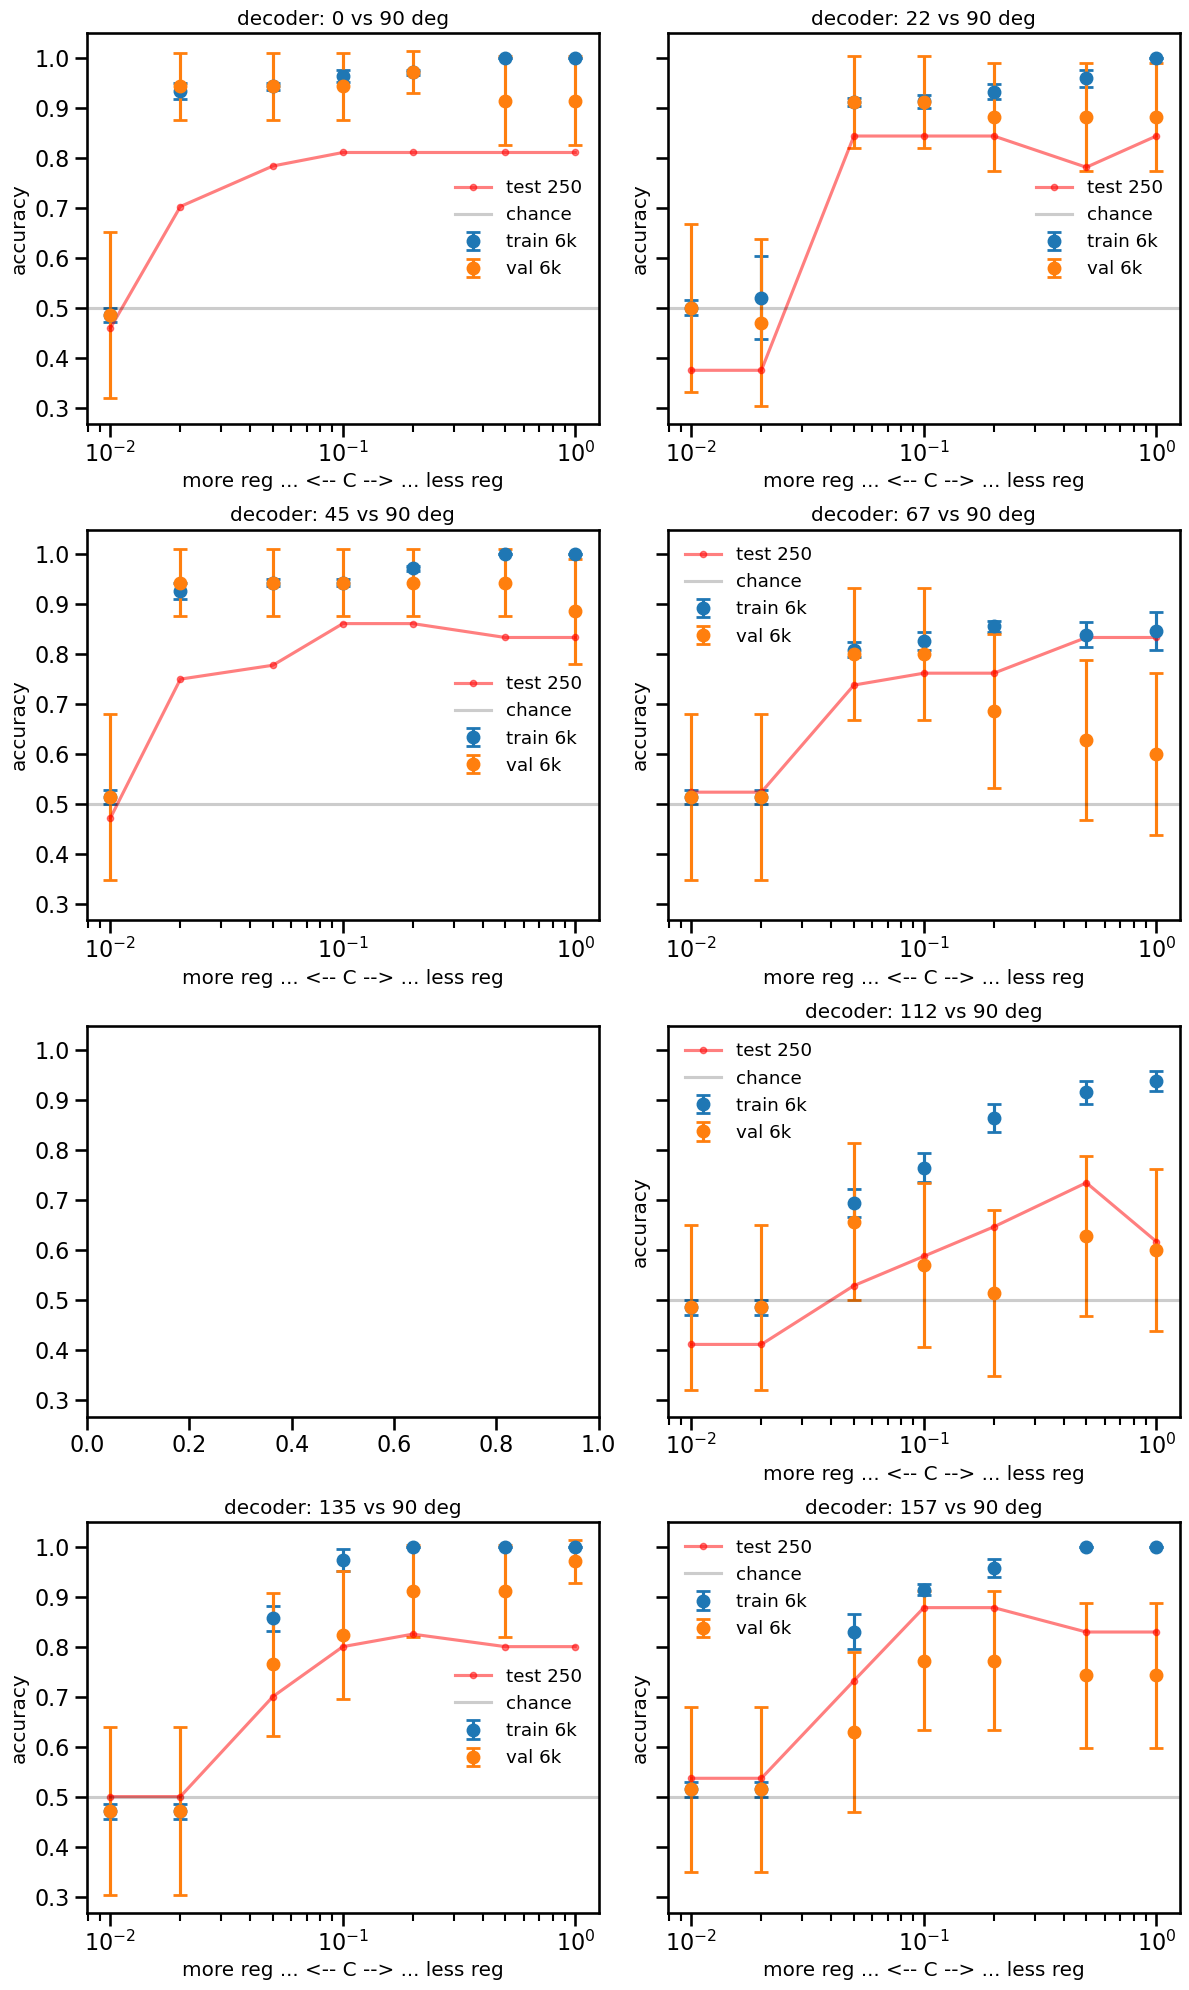

In [ ]:
## find optimal reg param C. 

nrow = 4
ncol = 2
fig, ax = plt.subplots(4, 2, figsize=(12, 20), sharey=True)

acc_val_mean_iori = []
acc_val_ci_iori = [] # confidence interval based on binomial distribution
acc_test_iori = []

for iori in tqdm(other_ori):
    
    ## get data for each pair of ori (another vs 90 deg)
    df_pair = df_svc[((df_svc.stim2_id == 4) | (df_svc.stim2_id == iori))]
    df_pair_250 = df_pair[df_pair.isi == 250]
    df_pair_6000 = df_pair[df_pair.isi == 6000]

    ## split train vs test for each isi
    X_train_250, y_train_250, X_test_250, y_test_250 = df_to_train_test(df_pair_250, train_only=True) # no test data
    X_train_6000, y_train_6000, X_test_6000, y_test_6000 = df_to_train_test(df_pair_6000, train_only=True)

    # ## stack training data across isi - ntrial per isi mostly balanced (30% vs 35%)
    # X_train = np.vstack((X_train_250, X_train_6000))
    # y_train = np.hstack((y_train_250, y_train_6000))
    # X_test = np.vstack((X_test_250, X_test_6000))
    # y_test = np.hstack((y_test_250, y_test_6000))

    # ## shuffle trials in the same way
    # seed_val = 0
    # np.random.seed(seed_val)
    # np.random.shuffle(X_train) # shuffled along the first axis, aka trials
    # np.random.shuffle(y_train)
    # np.random.shuffle(X_test)
    # np.random.shuffle(y_test)

    ## cross validation to find optimal C
    acc_train_mean = []
    acc_train_std = []
    acc_val_mean = []
    acc_val_std = []
    acc_val_ci = [] # confidence interval based on binomial distribution
    acc_test = []
    # C_list = [1e-4 * 10**i for i in range(8)] # 1e-4, 1e-3, ..., 1e3, 1e4
    C_list = [0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1] # zoom in around 0.1
    nfold = 5

    # use_data = 'isi=250' # train with unadapted, test with adapted
    # use_data = 'isi=6k' # train with unadapted, test with unadapted


    for C_val in C_list:
        clf = make_pipeline(StandardScaler(),
                            LinearSVC(tol=1e-5, max_iter=int(1e6), 
                                    penalty='l1', dual=False, C=C_val))

        ## train and val with isi 6k. val is considered as test
        score_val = cross_validate(clf, X_train_6000, y_train_6000, cv=LeaveOneOut(), return_train_score=True)        
        acc_train_mean.append(np.mean(score_val['train_score']))
        acc_train_std.append(np.std(score_val['train_score']))
        
        acc_val_mean.append(np.mean(score_val['test_score']))
        acc_val_std.append(np.std(score_val['test_score']))
        ci_low, ci_high = proportion_confint(count=score_val['test_score'].sum(), nobs=len(score_val['test_score']))
        ci_err = (ci_high - ci_low)/2
        acc_val_ci.append(ci_err)

        ## test with isi 250. train_250 is considered as test (bc model is trained with isi 6k)
        clf.fit(X_train_6000, y_train_6000)
        score_test = clf.score(X_train_250, y_train_250) # test data has only 1 trial. use train as test for isi 250
        acc_test.append(score_test)
        
    acc_val_mean_iori.append(acc_val_mean)
    acc_val_ci_iori.append(acc_val_ci)
    acc_test_iori.append(acc_test)
        
        
    ax[int(iori/ncol), iori%ncol].errorbar(x=C_list, y=acc_train_mean, 
                yerr=acc_train_std, fmt='o', capsize=5, capthick=2, label='train 6k')
    ax[int(iori/ncol), iori%ncol].errorbar(x=C_list, y=acc_val_mean,
                yerr=acc_val_ci, fmt='o', capsize=5, capthick=2, label='val 6k')
    ax[int(iori/ncol), iori%ncol].plot(C_list, acc_test, color='r', marker=".", alpha=0.5, label='test 250')
    ax[int(iori/ncol), iori%ncol].axhline(y=0.5, color='k',alpha=0.2, label='chance')

    # set x axis to log scale
    ax[int(iori/ncol), iori%ncol].set_xscale('log')

    ax[int(iori/ncol), iori%ncol].legend(frameon=False);
    ax[int(iori/ncol), iori%ncol].set_title(f'decoder: {int(22.5*iori)} vs 90 deg');
    ax[int(iori/ncol), iori%ncol].set_xlabel('more reg ... <-- C --> ... less reg');
    ax[int(iori/ncol), iori%ncol].set_ylabel('accuracy');
    
fig.tight_layout()

dir_fig = r'C:\Users\lan\Documents\repos\inter\results\decoder_grat8/'.replace('\\', '/')
fig.savefig(dir_fig + f'decoder_L1_train_val_6k_test_250.pdf', bbox_inches='tight')

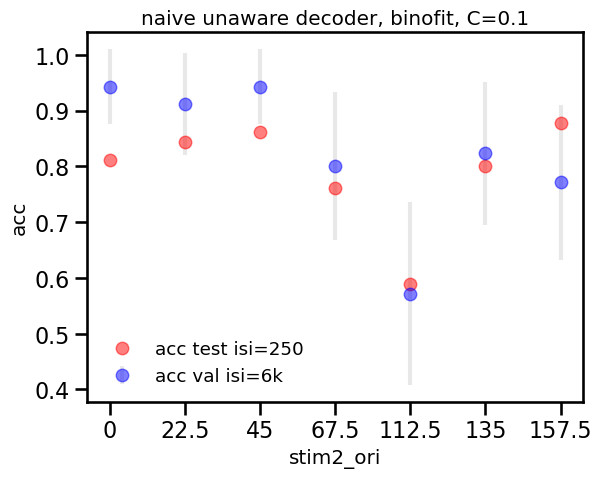

In [ ]:
fix_C = 0.1
# if use_data == 'isi=6k':
    # fix_C = 0.1
# if use_data == 'isi=250':
    # fix_C = 0.2
    
acc_val_C = np.array(acc_val_mean_iori)[:, np.where(np.array(C_list)==fix_C)[0][0]]
acc_val_ci_C = np.array(acc_val_ci_iori)[:, np.where(np.array(C_list)==fix_C)[0][0]]
acc_test_C = np.array(acc_test_iori)[:, np.where(np.array(C_list)==fix_C)[0][0]]

plt.errorbar(x=np.arange(len(stim2_ori_list)), 
             y=acc_val_C, 
             yerr=acc_val_ci_C, 
             label='acc val isi=6k',
             fmt='o', color='b', alpha=0.5, ecolor='lightgray', elinewidth=3, capsize=0);
plt.plot(acc_test_C, 'o', color='r', alpha=0.5, label='acc test isi=250')

stim2_ori_list = ['0', '22.5', '45', '67.5', '112.5', '135', '157.5']
plt.xticks(np.arange(len(stim2_ori_list)), stim2_ori_list);
plt.xlabel('stim2_ori')
plt.ylabel(f'acc');
plt.legend(frameon=False, loc='lower left')

title_str = f'naive unaware decoder, binofit, C={fix_C}'
plt.title(title_str);
plt.savefig(dir_fig + f'{title_str}.pdf', bbox_inches='tight')

### experienced unaware decoder (to clean)
train with both, test with either - assume decoder learned from visual xp

100%|██████████| 7/7 [00:17<00:00,  2.45s/it]


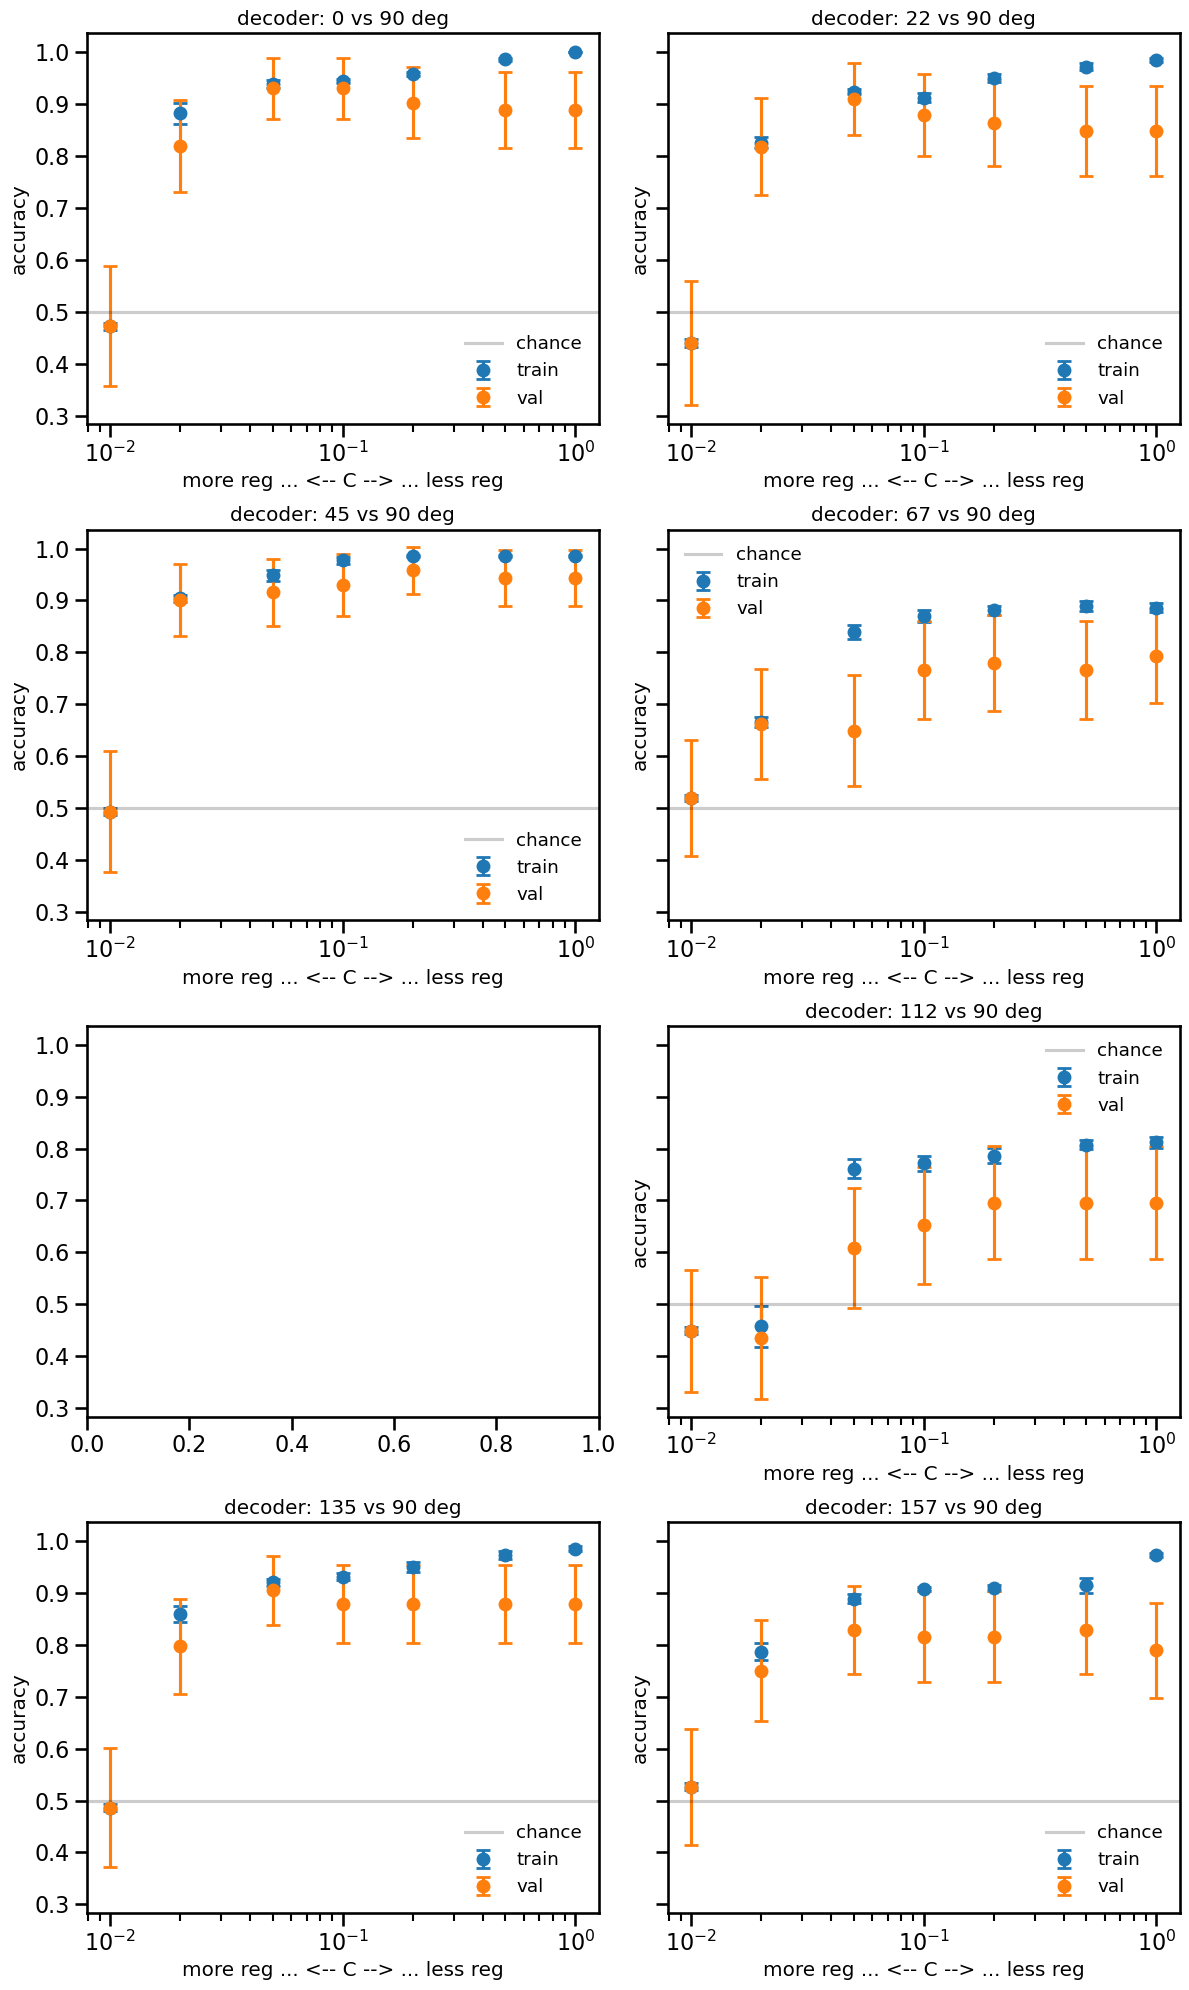

In [ ]:
## find optimal reg param C. 

nrow = 4
ncol = 2
cross_val_method = LeaveOneOut()
fig, ax = plt.subplots(4, 2, figsize=(12, 20), sharey=True)

acc_val_mean_iori = []
acc_val_ci_iori = [] # confidence interval based on binomial distribution
for iori in tqdm(other_ori):
    df_pair = df_svc[((df_svc.stim2_id == 4) | (df_svc.stim2_id == iori))]
    df_pair_250 = df_pair[df_pair.isi == 250]
    df_pair_6000 = df_pair[df_pair.isi == 6000]

    ## split train vs test for each isi
    X_train_250, y_train_250, X_test_250, y_test_250 = df_to_train_test(df_pair_250, train_only=True) # no test data
    X_train_6000, y_train_6000, X_test_6000, y_test_6000 = df_to_train_test(df_pair_6000, train_only=True)

    ## stack training data across isi - ntrial per isi mostly balanced (30% vs 35%)
    X_train = np.vstack((X_train_250, X_train_6000))
    y_train = np.hstack((y_train_250, y_train_6000))
    X_test = np.vstack((X_test_250, X_test_6000))
    y_test = np.hstack((y_test_250, y_test_6000))

    # ## shuffle trials in the same way
    # seed_val = 0
    # np.random.seed(seed_val)
    # np.random.shuffle(X_train) # shuffled along the first axis, aka trials
    # np.random.shuffle(y_train)
    # np.random.shuffle(X_test)
    # np.random.shuffle(y_test)

    ## cross validation to find optimal C
    acc_train_mean = []
    acc_train_std = []
    acc_val_mean = []
    acc_val_std = []
    acc_val_ci = [] # confidence interval based on binomial distribution
    acc_test = []
    # C_list = [1e-4 * 10**i for i in range(8)] # 1e-4, 1e-3, ..., 1e3, 1e4
    C_list = [0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1] # zoom in around 0.1
    nfold = 5

    use_data = 'isi_both'
    # use_data = 'isi=250' # adapted
    # use_data = 'isi=6k' # unadapted


    for C_val in C_list:
        clf = make_pipeline(StandardScaler(),
                            LinearSVC(tol=1e-5, max_iter=int(1e6), 
                                    penalty='l1', dual=False, C=C_val))
        
        if use_data == 'isi_both':
            score_val = cross_validate(clf, X_train, y_train, cv=cross_val_method, return_train_score=True) # instead of cv=nfold, use leave-one-out
        #     clf.fit(X_train, y_train)
        #     score_test = clf.score(X_test, y_test)
        # elif use_data == 'isi=250':
        #     score_val = cross_validate(clf, X_train_250, y_train_250, cv=cross_val_method, return_train_score=True)
        #     clf.fit(X_train_250, y_train_250)
        #     score_test = clf.score(X_test_250, y_test_250)
        # elif use_data == 'isi=6k':
        #     score_val = cross_validate(clf, X_train_6000, y_train_6000, cv=cross_val_method, return_train_score=True)
        #     clf.fit(X_train_6000, y_train_6000)
        #     score_test = clf.score(X_test_6000, y_test_6000)
        
        acc_train_mean.append(np.mean(score_val['train_score']))
        acc_train_std.append(np.std(score_val['train_score']))
        acc_val_mean.append(np.mean(score_val['test_score']))
        acc_val_std.append(np.std(score_val['test_score']))
        ci_low, ci_high = proportion_confint(count=score_val['test_score'].sum(), nobs=len(score_val['test_score']))
        ci_err = (ci_high - ci_low)/2
        acc_val_ci.append(ci_err)
        # acc_test.append(score_test)
    acc_val_mean_iori.append(acc_val_mean)
    acc_val_ci_iori.append(acc_val_ci)
        
        
    ax[int(iori/ncol), iori%ncol].errorbar(x=C_list, y=acc_train_mean, 
                yerr=acc_train_std, fmt='o', capsize=5, capthick=2, label='train')
    ax[int(iori/ncol), iori%ncol].errorbar(x=C_list, y=acc_val_mean,
                yerr=acc_val_ci, fmt='o', capsize=5, capthick=2, label='val')
    # ax[int(iori/ncol), iori%ncol].plot(C_list, acc_test, color='r', marker=".", alpha=0.5, label='test')
    ax[int(iori/ncol), iori%ncol].axhline(y=0.5, color='k',alpha=0.2, label='chance')

    # set x axis to log scale
    ax[int(iori/ncol), iori%ncol].set_xscale('log')

    ax[int(iori/ncol), iori%ncol].legend(frameon=False);
    ax[int(iori/ncol), iori%ncol].set_title(f'decoder: {int(22.5*iori)} vs 90 deg');
    ax[int(iori/ncol), iori%ncol].set_xlabel('more reg ... <-- C --> ... less reg');
    ax[int(iori/ncol), iori%ncol].set_ylabel('accuracy');
    
fig.tight_layout()

dir_fig = r'C:\Users\lan\Documents\repos\inter\results\decoder_grat8/'.replace('\\', '/')
fig.savefig(dir_fig + f'decoder_L1_leave1out.pdf', bbox_inches='tight')

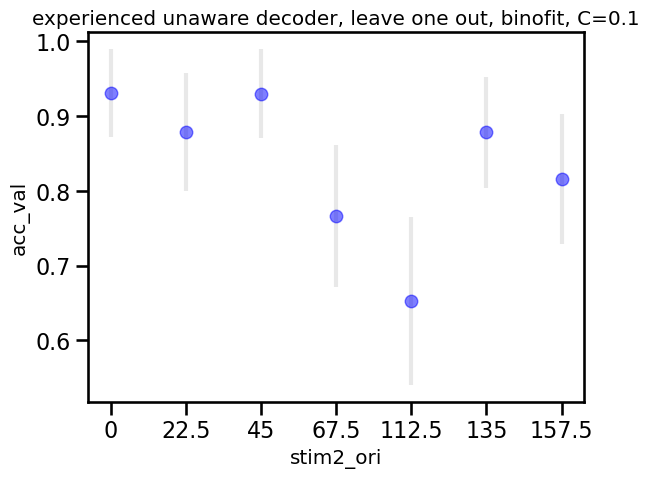

In [ ]:
fix_C = 0.1
    
acc_val_C = np.array(acc_val_mean_iori)[:, np.where(np.array(C_list)==fix_C)[0][0]]
acc_val_ci_C = np.array(acc_val_ci_iori)[:, np.where(np.array(C_list)==fix_C)[0][0]]

plt.errorbar(x=np.arange(len(stim2_ori_list)), 
             y=acc_val_C, 
             yerr=acc_val_ci_C, 
             fmt='o', color='b', alpha=0.5, ecolor='lightgray', elinewidth=3, capsize=0);

stim2_ori_list = ['0', '22.5', '45', '67.5', '112.5', '135', '157.5']
plt.xticks(np.arange(len(stim2_ori_list)), stim2_ori_list);
plt.xlabel('stim2_ori')
plt.ylabel(f'acc_val');

title_str = f'experienced unaware decoder, leave one out, binofit, C={fix_C}'
plt.title(title_str);
plt.savefig(dir_fig + f'{title_str}.pdf', bbox_inches='tight')

# decoder across area
area subplot, isi color, date_sess concat acc errorbar  
fixed C

In [53]:
df_svc.cell_id.unique()

array(['230309_002_0', '230309_002_51', '230309_002_79'], dtype=object)

In [58]:
tmp = df_tidy.stim2_id.unique()
other_ori = sorted(tmp[tmp != 4]) # decode 90 vs not 90

ncell_keep = 15
if ncell_keep <= 15:
    C_init = 0.1
elif ncell_keep == 999:
    C_init = 0.05
# C_init = 1 # if without standard scaler z score


decode_res_areas = []
for iarea in ['V1', 'LM', 'LI']:
    true_pos_isi = []
    n_sample_isi = []

    for use_data in ['isi=250', 'isi=6k']:
        true_pos_ori = np.zeros(len(other_ori) + 1) # true positive across ori pairs. leave a blank for stim2_id=4 (90 deg)
        n_sample_ori = np.zeros(len(other_ori) + 1)
        nsess_iarea = (df_tidy[(df_tidy.area == iarea) 
                            & (df_tidy.filter_cell_vis == True)] # some LI sessions have no vis cell
                        .groupby(['date', 'sess'])
                        .first().__len__())
        
        for isess in tqdm(range(nsess_iarea)):
            df_svc = get_df_svc(df_tidy, iarea=iarea, idatesess=isess, 
                                ncell_keep=ncell_keep, filter_cell='SNR_R1_mod')
            if df_svc.cell_id.nunique() < 5:
                print(f'not enough vis cells: area={iarea}, sess={isess}')
                continue

            for iori in (other_ori):
                df_pair = df_svc[((df_svc.stim2_id == 4) | (df_svc.stim2_id == iori))]
                df_pair_250 = df_pair[df_pair.isi == 250]
                df_pair_6000 = df_pair[df_pair.isi == 6000]

                X_train_250, y_train_250, X_test_250, y_test_250 = df_to_train_test(df_pair_250, train_only=True) # no test data
                X_train_6000, y_train_6000, X_test_6000, y_test_6000 = df_to_train_test(df_pair_6000, train_only=True)

                C_current = C_init # reset C_current, then find optimal C for this area-isi-sess-ori
                while (C_current >= 0.01) & (C_current <= 10):
                    clf = make_pipeline(StandardScaler(),
                                        LinearSVC(tol=1e-5, max_iter=int(1e7), 
                                                penalty='l1', dual='auto', C=C_current))
                    
                    if use_data == 'isi=250':
                        score_val = cross_validate(clf, X_train_250, y_train_250, cv=LeaveOneOut(), return_train_score=True)
                    elif use_data == 'isi=6k':
                        score_val = cross_validate(clf, X_train_6000, y_train_6000, cv=LeaveOneOut(), return_train_score=True)

                    if np.mean(score_val['train_score']) - np.std(score_val['train_score']) <= 0.5: # lower err of train acc is too low, underfit
                        C_current *= 2
                        print(f'train acc underfit: area={iarea}, sess={isess}, isi={use_data}, ori={iori}')
                    elif np.mean(score_val['train_score']) + np.std(score_val['train_score']) >= 1: # upper err of train acc is too high, overfit
                        C_current /= 2
                        print(f'train acc overfit: area={iarea}, sess={isess}, isi={use_data}, ori={iori}')
                    else:
                        if (C_current <= C_init / (2**3)) or (C_current >= C_init * (2**3)): # too many tries, give up fitting
                            print(f'unable to fit: area={iarea}, sess={isess}, isi={use_data}, ori={iori}, C={C_current}')
                            break
                        else:
                            true_pos = score_val['test_score'].sum()
                            n_sample = len(score_val['test_score'])
                            ci_low, ci_high = proportion_confint(count=true_pos, nobs=n_sample)
                            if (true_pos/n_sample >= 0.5) & (true_pos/n_sample < 1): # avoid val acc underfit or overfit result
                                true_pos_ori[iori] += true_pos
                                n_sample_ori[iori] += n_sample
                            elif true_pos/n_sample < 0.5:
                                print(f'val acc underfit: area={iarea}, sess={isess}, isi={use_data}, ori={iori}')
                            elif true_pos/n_sample >= 1:
                                print(f'val acc overfit: area={iarea}, sess={isess}, isi={use_data}, ori={iori}')
                            break # record res, stop searching for C
        
        true_pos_isi.append(true_pos_ori)
        n_sample_isi.append(n_sample_ori)
    decode_res_areas.append([true_pos_isi, n_sample_isi])

 33%|███▎      | 2/6 [00:04<00:09,  2.25s/it]

train acc overfit: area=V1, sess=1, isi=isi=250, ori=6


 17%|█▋        | 1/6 [00:02<00:11,  2.21s/it]

train acc overfit: area=V1, sess=0, isi=isi=6k, ori=7


 33%|███▎      | 2/6 [00:04<00:08,  2.21s/it]

train acc overfit: area=V1, sess=1, isi=isi=6k, ori=7


 67%|██████▋   | 4/6 [00:08<00:04,  2.23s/it]

train acc overfit: area=V1, sess=3, isi=isi=6k, ori=7
train acc overfit: area=V1, sess=3, isi=isi=6k, ori=7


  5%|▍         | 1/22 [00:02<00:49,  2.34s/it]

val acc underfit: area=LM, sess=1, isi=isi=250, ori=0
val acc underfit: area=LM, sess=1, isi=isi=250, ori=1
val acc underfit: area=LM, sess=1, isi=isi=250, ori=2


  9%|▉         | 2/22 [00:04<00:46,  2.32s/it]

val acc underfit: area=LM, sess=2, isi=isi=250, ori=5


 14%|█▎        | 3/22 [00:07<00:44,  2.35s/it]

val acc underfit: area=LM, sess=3, isi=isi=250, ori=3


 36%|███▋      | 8/22 [00:26<00:57,  4.13s/it]

train acc overfit: area=LM, sess=8, isi=isi=250, ori=6
train acc overfit: area=LM, sess=8, isi=isi=250, ori=6


 41%|████      | 9/22 [00:29<00:46,  3.61s/it]

val acc underfit: area=LM, sess=9, isi=isi=250, ori=3


 55%|█████▍    | 12/22 [00:36<00:27,  2.73s/it]

val acc underfit: area=LM, sess=11, isi=isi=250, ori=6
val acc underfit: area=LM, sess=12, isi=isi=250, ori=0
val acc underfit: area=LM, sess=12, isi=isi=250, ori=1
val acc underfit: area=LM, sess=12, isi=isi=250, ori=2
val acc underfit: area=LM, sess=12, isi=isi=250, ori=3
val acc underfit: area=LM, sess=12, isi=isi=250, ori=5


 59%|█████▉    | 13/22 [00:38<00:23,  2.59s/it]

val acc underfit: area=LM, sess=12, isi=isi=250, ori=6
val acc underfit: area=LM, sess=12, isi=isi=250, ori=7


 64%|██████▎   | 14/22 [00:40<00:20,  2.52s/it]

val acc underfit: area=LM, sess=14, isi=isi=250, ori=2
val acc underfit: area=LM, sess=14, isi=isi=250, ori=3


 68%|██████▊   | 15/22 [00:42<00:17,  2.45s/it]

val acc underfit: area=LM, sess=15, isi=isi=250, ori=5


 73%|███████▎  | 16/22 [00:45<00:14,  2.41s/it]

train acc underfit: area=LM, sess=16, isi=isi=250, ori=3
train acc underfit: area=LM, sess=16, isi=isi=250, ori=3
val acc underfit: area=LM, sess=16, isi=isi=250, ori=3


 77%|███████▋  | 17/22 [00:47<00:12,  2.44s/it]

val acc underfit: area=LM, sess=16, isi=isi=250, ori=6


 86%|████████▋ | 19/22 [00:52<00:07,  2.40s/it]

val acc underfit: area=LM, sess=19, isi=isi=250, ori=5


 91%|█████████ | 20/22 [00:54<00:04,  2.40s/it]

val acc underfit: area=LM, sess=20, isi=isi=250, ori=3


 95%|█████████▌| 21/22 [00:57<00:02,  2.37s/it]

val acc underfit: area=LM, sess=21, isi=isi=250, ori=0
val acc underfit: area=LM, sess=21, isi=isi=250, ori=2
val acc underfit: area=LM, sess=21, isi=isi=250, ori=3
val acc underfit: area=LM, sess=21, isi=isi=250, ori=5


100%|██████████| 22/22 [00:59<00:00,  2.71s/it]

val acc underfit: area=LM, sess=21, isi=isi=250, ori=7



  9%|▉         | 2/22 [00:04<00:43,  2.18s/it]

val acc underfit: area=LM, sess=1, isi=isi=6k, ori=5


 23%|██▎       | 5/22 [00:10<00:37,  2.21s/it]

train acc overfit: area=LM, sess=4, isi=isi=6k, ori=7
val acc underfit: area=LM, sess=5, isi=isi=6k, ori=3


 27%|██▋       | 6/22 [00:13<00:35,  2.21s/it]

val acc underfit: area=LM, sess=6, isi=isi=6k, ori=3


 32%|███▏      | 7/22 [00:15<00:33,  2.21s/it]

train acc overfit: area=LM, sess=7, isi=isi=6k, ori=0


 36%|███▋      | 8/22 [00:17<00:31,  2.25s/it]

train acc overfit: area=LM, sess=7, isi=isi=6k, ori=6
train acc overfit: area=LM, sess=8, isi=isi=6k, ori=0


 45%|████▌     | 10/22 [00:22<00:26,  2.25s/it]

val acc underfit: area=LM, sess=9, isi=isi=6k, ori=5


 50%|█████     | 11/22 [00:24<00:24,  2.23s/it]

val acc underfit: area=LM, sess=11, isi=isi=6k, ori=3


 59%|█████▉    | 13/22 [00:28<00:19,  2.19s/it]

val acc underfit: area=LM, sess=12, isi=isi=6k, ori=6
val acc underfit: area=LM, sess=13, isi=isi=6k, ori=2
val acc underfit: area=LM, sess=13, isi=isi=6k, ori=3


 73%|███████▎  | 16/22 [00:35<00:13,  2.19s/it]

val acc underfit: area=LM, sess=15, isi=isi=6k, ori=5
val acc underfit: area=LM, sess=16, isi=isi=6k, ori=3


100%|██████████| 22/22 [00:48<00:00,  2.21s/it]

val acc underfit: area=LM, sess=21, isi=isi=6k, ori=5



  7%|▋         | 1/15 [00:02<00:30,  2.19s/it]

val acc underfit: area=LI, sess=1, isi=isi=250, ori=2
val acc underfit: area=LI, sess=1, isi=isi=250, ori=3


 20%|██        | 3/15 [00:05<00:22,  1.86s/it]

not enough vis cells: area=LI, sess=2
val acc underfit: area=LI, sess=3, isi=isi=250, ori=2
val acc underfit: area=LI, sess=3, isi=isi=250, ori=5


 33%|███▎      | 5/15 [00:09<00:17,  1.79s/it]

not enough vis cells: area=LI, sess=4


 40%|████      | 6/15 [00:10<00:15,  1.68s/it]

not enough vis cells: area=LI, sess=5
val acc underfit: area=LI, sess=6, isi=isi=250, ori=2
val acc underfit: area=LI, sess=6, isi=isi=250, ori=3


 47%|████▋     | 7/15 [00:13<00:14,  1.84s/it]

val acc underfit: area=LI, sess=7, isi=isi=250, ori=0


 60%|██████    | 9/15 [00:16<00:10,  1.78s/it]

not enough vis cells: area=LI, sess=8


 67%|██████▋   | 10/15 [00:18<00:08,  1.69s/it]

not enough vis cells: area=LI, sess=9
val acc underfit: area=LI, sess=10, isi=isi=250, ori=3


 80%|████████  | 12/15 [00:21<00:05,  1.72s/it]

not enough vis cells: area=LI, sess=11


 87%|████████▋ | 13/15 [00:24<00:03,  1.88s/it]

val acc underfit: area=LI, sess=13, isi=isi=250, ori=2
val acc underfit: area=LI, sess=13, isi=isi=250, ori=3


100%|██████████| 15/15 [00:27<00:00,  1.85s/it]

not enough vis cells: area=LI, sess=14



  7%|▋         | 1/15 [00:02<00:29,  2.07s/it]

val acc underfit: area=LI, sess=0, isi=isi=6k, ori=5


 20%|██        | 3/15 [00:05<00:21,  1.79s/it]

not enough vis cells: area=LI, sess=2
val acc underfit: area=LI, sess=3, isi=isi=6k, ori=3


 33%|███▎      | 5/15 [00:09<00:17,  1.73s/it]

not enough vis cells: area=LI, sess=4


 40%|████      | 6/15 [00:10<00:14,  1.65s/it]

not enough vis cells: area=LI, sess=5
val acc underfit: area=LI, sess=6, isi=isi=6k, ori=1
val acc underfit: area=LI, sess=6, isi=isi=6k, ori=2


 47%|████▋     | 7/15 [00:12<00:14,  1.79s/it]

val acc underfit: area=LI, sess=6, isi=isi=6k, ori=7
val acc underfit: area=LI, sess=7, isi=isi=6k, ori=1
val acc underfit: area=LI, sess=7, isi=isi=6k, ori=5
train acc underfit: area=LI, sess=7, isi=isi=6k, ori=6
train acc underfit: area=LI, sess=7, isi=isi=6k, ori=6


 53%|█████▎    | 8/15 [00:14<00:13,  1.92s/it]

val acc underfit: area=LI, sess=7, isi=isi=6k, ori=6


 60%|██████    | 9/15 [00:16<00:10,  1.77s/it]

not enough vis cells: area=LI, sess=8


 67%|██████▋   | 10/15 [00:17<00:08,  1.68s/it]

not enough vis cells: area=LI, sess=9


 80%|████████  | 12/15 [00:21<00:05,  1.69s/it]

not enough vis cells: area=LI, sess=11


100%|██████████| 15/15 [00:26<00:00,  1.80s/it]

not enough vis cells: area=LI, sess=14


In [59]:
# grat8_decode_SNR_R1_mod = {'decode_res_areas': decode_res_areas}
# with open(dir_fig + 'grat8_decode_SNR_R1_mod.pickle', 'wb') as f:
#     pickle.dump(grat8_decode_SNR_R1_mod, f)

# grat8_decode_all_cell = {'decode_res_areas': decode_res_areas}
# with open(dir_fig + 'grat8_decode_all_cell.pickle', 'wb') as f:
#     pickle.dump(grat8_decode_all_cell, f)

decode_res_areas

[[[array([227., 207., 184., 171.,   0., 192., 202., 226.]),
   array([187., 176., 179., 146.,   0., 162., 169., 176.])],
  [array([263., 242., 228., 250.,   0., 248., 242., 254.]),
   array([212., 209., 210., 209.,   0., 208., 209., 207.])]],
 [[array([609., 640., 532., 397.,   0., 465., 623., 654.]),
   array([634., 592., 549., 400.,   0., 426., 596., 649.])],
  [array([787., 861., 754., 639.,   0., 715., 822., 819.]),
   array([788., 786., 756., 613.,   0., 641., 756., 784.])]],
 [[array([209., 236., 122., 102.,   0., 196., 232., 255.]),
   array([217., 155., 162., 147.,   0., 137., 169., 184.])],
  [array([302., 346., 175., 171.,   0., 312., 336., 345.]),
   array([284., 214., 247., 248.,   0., 213., 251., 246.])]]]

## plot single area across isi

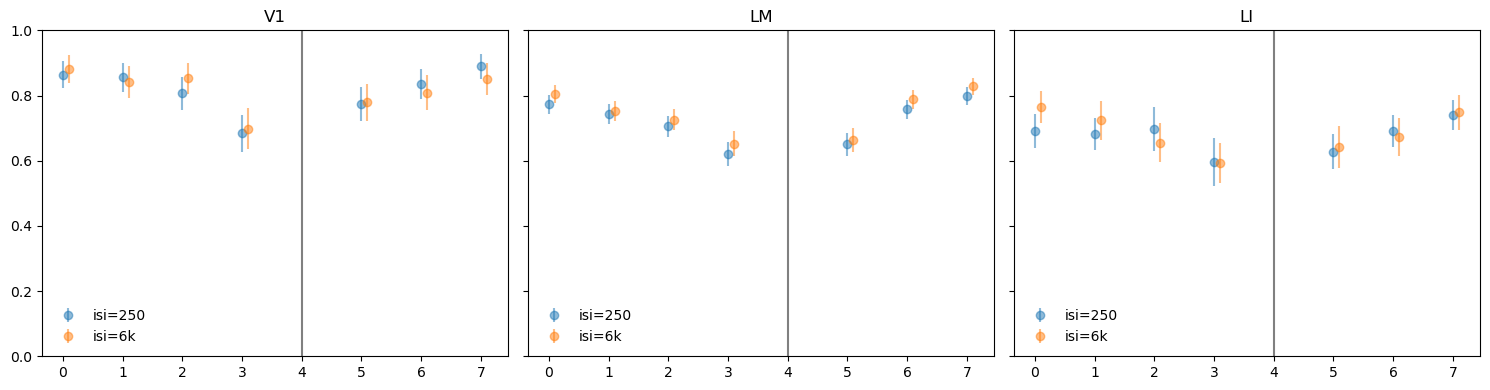

In [60]:
warnings.filterwarnings('ignore') # suppress RuntimeWarning: invalid value encountered in true_divide
isi_list = ['isi=250', 'isi=6k']
nisi = len(isi_list)
fig, ax = plt.subplots(1, 3, figsize=(15, 4), sharey=True)

for (i, iarea) in enumerate(['V1', 'LM', 'LI']):
    true_pos_isi, n_sample_isi = decode_res_areas[i]
    
    for iisi in range(nisi):
        ci_low, ci_high = proportion_confint(count=true_pos_isi[iisi], 
                                            nobs=n_sample_isi[iisi])
        ci_err = (ci_high - ci_low)/2
        
        ax[i].errorbar(x=np.arange(8) + iisi*0.1, 
                    y=true_pos_isi[iisi] / n_sample_isi[iisi], 
                    yerr=ci_err, 
                    label=isi_list[iisi], fmt='o', alpha=0.5);

    ax[i].axvline(x=4, color='gray', linestyle='-');
    ax[i].set_ylim(0, 1);
    ax[i].legend(frameon=False, loc='lower left');
    ax[i].set_title(iarea);
    
plt.tight_layout();
dir_fig = os.path.join(dir_repo, r'results\decoder_grat8\aware decoder/'.replace('\\', '/'))
# fig.savefig(dir_fig + 'grat8_decode_15_cell_flexible_regC_val_acc_filter.pdf', bbox_inches='tight')